In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pandas.set_option('display.max_columns', 10)
pandas.set_option('display.width', 350)

//miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#read the two files
video_count=pandas.read_csv("./dataset/video_sharing/video_count.csv")

In [3]:
video_count.head()

,video_id,count,date
0,2303,22,2015-01-07
1,1193,54854,2015-01-12
2,1219,1788779,2015-01-03
3,1472,234,2015-01-04
4,2947,14407,2015-01-08


In [6]:
video_count.shape

(41775, 3)

In [9]:
video_count.video_id.nunique()

2785

In [4]:
video_features=pandas.read_csv("./dataset/video_sharing/video_features.csv")

In [5]:
video_features.head()

,video_id,video_length,video_language,video_upload_date,video_quality
0,2374,1760,Cn,2014-12-06,480p
1,1897,489,Cn,2014-12-10,720p
2,2386,1273,Es,2014-12-05,480p
3,2912,986,Es,2014-12-10,240p
4,2432,1050,Other,2014-12-10,480p


In [13]:
video_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2785 entries, 0 to 2784
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   video_id           2785 non-null   int64 
 1   video_length       2785 non-null   int64 
 2   video_language     2785 non-null   object
 3   video_upload_date  2785 non-null   object
 4   video_quality      2785 non-null   object
dtypes: int64(2), object(3)
memory usage: 108.9+ KB


In [8]:
video_features.shape

(2785, 5)

In [10]:
#join them on video_id
data=pandas.merge(video_count, video_features,on='video_id', how='left')

In [11]:
data.shape

(41775, 7)

In [12]:
data.describe(include='all')

,video_id,count,date,video_length,video_language,video_upload_date,video_quality
count,41775.000000,4.177500e+04,41775,41775.000000,41775,41775,41775
unique,NaN,NaN,15,NaN,6,23,5
top,NaN,NaN,2015-01-15,NaN,Cn,2014-12-10,1080p
freq,NaN,NaN,2785,NaN,12570,3630,11940
mean,1498.673250,6.243710e+05,NaN,684.813285,NaN,NaN,NaN
std,864.094856,8.879097e+05,NaN,422.420884,NaN,NaN,NaN
min,1.000000,1.000000e+00,NaN,9.000000,NaN,NaN,NaN
25%,754.000000,9.095500e+03,NaN,363.000000,NaN,NaN,NaN
50%,1492.000000,1.795580e+05,NaN,631.000000,NaN,NaN,NaN
75%,2236.000000,9.043615e+05,NaN,973.000000,NaN,NaN,NaN


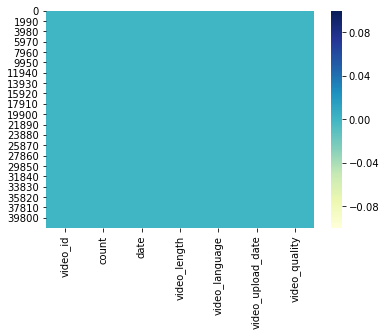

In [14]:
sns.heatmap(data.isnull(),cmap = 'YlGnBu')

Q: Classify each video into one these 3 categories: “Hot”, “Stable and Popular”, “Everything Else”

Hot is defined as trending up. Therefore, for each video, we can look at the view count percentage change day by day. And pick the videos with the highest average.

In [15]:
#For all video_ids, are all dates consecutive? Or do we have missing days?
#Firstly, we sort by date
data_class = data.sort_values(by='date')
  
#Then we check that date difference for each video_id between consecutive rows is always one
consecutive_days = data_class.groupby('video_id')['date'].transform(lambda x: pandas.to_datetime(x).diff()) 
  
#Good. All days are consecutives
print(consecutive_days.dropna().unique().astype('timedelta64[D]'))

[1]


In [16]:
consecutive_days

18227      NaT
21967      NaT
5581       NaT
5583       NaT
21972      NaT
         ...  
24676   1 days
30588   1 days
8588    1 days
39203   1 days
32395   1 days
Name: date, Length: 41775, dtype: timedelta64[ns]

In [18]:
#So we can just estimate percentage change day by day by taking (current_row/previous_row) - 1
data_class['pct_change'] = data_class.groupby('video_id')['count'].apply(lambda x: x/x.shift(1)-1)
  
#And now we can take the average of pct_change as well as the average count overall
data_class = data_class.groupby('video_id').apply( lambda x: pandas.Series({
                            'avg_pct_change': x['pct_change'].mean(),
                            'avg_count': x['count'].mean() })
).reset_index() 


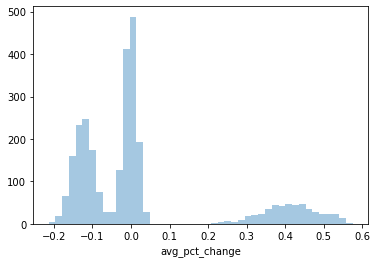

In [19]:
#Let's plot avg_pct_change
sns.distplot(data_class['avg_pct_change'], kde=False)

There seems to be two clear groups: one above 0.2 and one below. Let’s define as “hot” all videos whose average percentage change is > 0.2.

The next step is separating “Stable and Popular” (i.e. view count percentage change is flat, but count is very high) vs everything else.


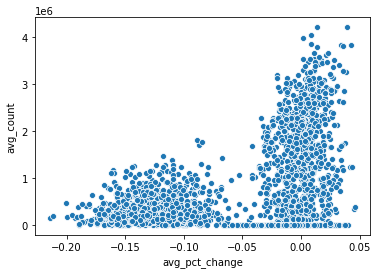

In [20]:
#Let's plot all remaining videos across those two dimensions to see if we can find the two groups manually
sns.scatterplot(data=data_class.query('avg_pct_change<0.2'), x="avg_pct_change", y="avg_count")
plt.show()

In terms of percentage change, there seems to be a clear cut-off around -0.05. We can define videos whose percentage change is between -0.05 and +0.05 as stable. After all, it means that view count for these videos is within 5%, which is a pretty safe value for “stable”
Regarding absolute view count, there doesn’t appear to be a clear cut-off. Looking at the plot, it looks reasonable to pick a cut-off around 2 millions. All videos trending down are below that value as well as most of the stable videos.

In [21]:
#Let's assign the classes using the strategies described above
data_class['class'] = np.where(data_class['avg_pct_change']>0.2, "hot",
                      np.where((data_class['avg_pct_change']>-0.05) & (data_class['avg_count']>2000000), "stable and popular", "everything else"))


In [22]:
#Let's check the count
print(data_class['class'].value_counts())

everything else       1982
hot                    500
stable and popular     303
Name: class, dtype: int64


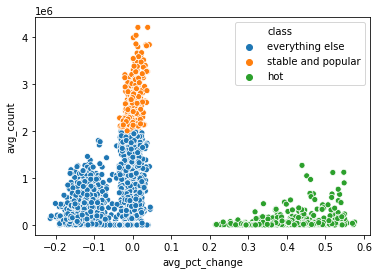

In [23]:
#Let's plot the clusters
sns.scatterplot(data=data_class, x="avg_pct_change", y="avg_count", hue="class")
plt.show()

Final results make sense from a visual standpoint. Another approach could have been going by percentile. That is, deciding that the top X% would have been considered high view counts and high percentage change. And then create the groups accordingly.

Q: What are the main characteristics of the “hot videos”?

Since we already have the labels, we can simply build a machine learning classifier trying to separate hot videos from the other ones. We can use a decision tree here since we care mainly about the descriptive statistics part and less about the actual prediction.

In [24]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
  
#Add label to data
data_tree=pandas.merge(left=video_features, right=data_class[["video_id", "class"]], how='left')
data_tree['class'] = np.where(data_tree['class']=="hot", 1, 0)
  
#Extract week of the year and day of the week from date
data_tree['upload_weekday']  = pandas.to_datetime(data_tree['video_upload_date']).dt.strftime('%A')
data_tree['upload_weekyear'] = pandas.to_datetime(data_tree['video_upload_date']).dt.strftime('%U').astype(int)
del data_tree['video_upload_date'] 
del data_tree['video_id']
  
#prepare the data for the model by creating dummy vars and removing the label
data_dummy = pandas.get_dummies(data_tree, drop_first=True)
train_cols = data_dummy.drop('class', axis=1)
  
#build the tree
tree=DecisionTreeClassifier(
    #set max tree dept at 4. Bigger than that it just becomes too messy
    max_depth=4,
    #change weights given that we have unbalanced classes. Our data set is now perfectly balanced. It makes easier to look at tree output
    class_weight="balanced",
    #only split if it's worthwhile. The default value of 0 means always split no matter what if you can increase overall performance, which might lead to irrelevant splits
    min_impurity_decrease = 0.001
    )
tree.fit(train_cols,data_dummy['class'])
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.001, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
#visualize it
export_graphviz(tree, out_file="tree_video_sharing.dot", feature_names=train_cols.columns, proportion=True, rotate=True)
with open("tree_video_sharing.dot") as f:
    dot_graph = f.read()


In [25]:
s = Source.from_file("tree_video_sharing.dot")
s.view()

'tree_video_sharing.dot.pdf'

The tree conclusions are pretty clear. By far the main thing is that Hot videos cannot be the old ones (first split). This is not surprising as hot videos tend to be the ones recently uploaded. After all, hot videos are defined as those with a very high video count increase day by day (>20%). And you cannot really grow at that rate for too long.
That being said, that is not too actionable. A possible insight based on that would be suggesting users to often upload new videos, given that the “hotness life cycle” is pretty short. But beside that, what are the actual characteristics of a video that make it more likely to become hot?
Let’s rebuild the tree w/o the time-related variables.

In [26]:
#build the tree w/o time variables
data_dummy = pandas.get_dummies(data_tree[['video_length', 'video_language', 'video_quality', 'class']], drop_first=True)
train_cols = data_dummy.drop('class', axis=1)
  
#build the tree
tree_no_time=DecisionTreeClassifier(
    #set max tree dept at 4. Bigger than that it just becomes too messy
    max_depth=4,
    #change weights given that we have unbalanced classes. Our data set is now perfectly balanced. It makes easier to look at tree output
    class_weight="balanced",
    #only split if it's worthwhile. The default value of 0 means always split no matter what if you can increase overall performance, which might lead to irrelevant splits
    min_impurity_decrease = 0.001
    )
tree_no_time.fit(train_cols,data_dummy['class'])
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.001, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
#visualize it
export_graphviz(tree_no_time, out_file="tree_video_sharing_no_time.dot", feature_names=train_cols.columns, proportion=True, rotate=True)
with open("tree_video_sharing_no_time.dot") as f:
    dot_graph = f.read()
  
s = Source.from_file("tree_video_sharing_no_time.dot")
s.view()

'tree_video_sharing_no_time.dot.pdf'

This gets more interesting.
Video_length is crucial. Shorter videos are better. Interesting, there seems to be clear cut-offs around 13 minutes (791 seconds), 7 minutes (399 seconds), 21 minutes (1290 seconds). The shorter the video, always the higher is the probability of being hot
Language doesn’t appear as relevant as video_length. However we can see that English always leads to higher probability of a video being hot. On the other hand, language “other” leads to lower probability.
It could be interesting now to validate these findings by building a random forest and look at the partial dependence plots. In general, RF is a better model compared to a single tree (obviously), so we would expect RF findings to be a bit more detailed.

Q: After having identified the characteristics of the hot videos, how would you use this information from a product standpoint?

Let’s take video_length as an example here. Obviously, the goal is to have users upload shorter videos. Specifically, we found out that less than 7 minutes is an optimal time_length and > 21 minutes is extremely bad. There are three possible approaches here:

1 Run a test where you only allow users to upload a video if length is smaller than a given threshold and see what happens (this is a particularly aggressive approach and rarely gets implemented)

2 If a user uploads a video that has bad characteristics (i.e. too long), have a pop-up/notification telling them that if their video had certain characteristics (i.e. shorter), they could get X% more views and, therefore, make Y% more money in ads-revenue. Test it and see what happens (this is far more common than point 1)

3A hybrid of point 1 and 2. I.e. if a video is > 21 minutes, don’t allow the user to upload it. If it is <21 minutes, but >7 minutes, have the pop-up with the suggestion